# 🧠 Step 1: Dataset Setup & Preview

This cell prepares your dataset by:
- Scanning the `data/raw/` folder
- Creating an output folder for each image
- Previewing the first few schematics


In [56]:
# ─── ensure correct import ───
import sys, os
from pathlib import Path

# 1) figure out project root (one level above notebooks/)
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

# 2) import your function
from scripts.image_utils import preprocess_image

import cv2

# 3) prepare directories *relative to project root*
RAW_DIR          = PROJECT_ROOT / "data" / "raw"
PREPROCESSED_DIR = PROJECT_ROOT / "data" / "preprocessed"
PREPROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# 4) process images
raw_files = [f for f in os.listdir(RAW_DIR) if f.lower().endswith(('.png','.jpg','.jpeg'))]
for fname in raw_files:
    img_path = RAW_DIR / fname
    img = cv2.imread(str(img_path))
    if img is None:
        print("❌", fname, "failed to load.")
        continue

    pid = Path(fname).stem
    out = preprocess_image(img)

    output_path = PREPROCESSED_DIR / f"{pid}.png"
    cv2.imwrite(str(output_path), out)
    # print("✅", pid, "done")


In [57]:
import sys
from pathlib import Path

# 1) locate project root (one level above notebooks/)
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# 2) make sure scripts/ is importable
sys.path.insert(0, str(PROJECT_ROOT))

# 3) now import your helpers
from scripts.image_utils import (
    list_images,
    create_output_folders,
    load_image,
    preview_image
)

# 4) set your data paths relative to project root
RAW_DIR  = PROJECT_ROOT / "data" / "preprocessed"
PROC_DIR = PROJECT_ROOT / "data" / "processed"

# 5) directory sanity check
if not RAW_DIR.exists():
    raise FileNotFoundError(f"Preprocessed folder not found: {RAW_DIR}")
if not PROC_DIR.exists():
    PROC_DIR.mkdir(parents=True)
    print(f"→ Created processed folder: {PROC_DIR}")

# 6) list images and create outputs
image_files = list_images(RAW_DIR)
print(f"Found {len(image_files)} images in {RAW_DIR}")

create_output_folders(image_files, PROC_DIR)



Debug: Found 330 images in /Users/fatihbasturk/Projects/EE58A-2025/data/preprocessed
Found 330 images in /Users/fatihbasturk/Projects/EE58A-2025/data/preprocessed


In [58]:
import pandas as pd

# PROJECT_ROOT should be the folder above notebooks/
# e.g. from previous cell:
# PROJECT_ROOT = Path.cwd().parent if Path.cwd().name=="notebooks" else Path.cwd()

# build metadata with full paths
metadata = pd.DataFrame({
    "filename": [f.name for f in image_files],
    "path":     [str(f) for f in image_files],
    "status":   ["unprocessed"] * len(image_files)
})

# write into project/data/metadata.csv
out_csv = PROJECT_ROOT / "data" / "metadata.csv"
metadata.to_csv(str(out_csv), index=False)
print(f"✅ metadata saved to {out_csv}")


✅ metadata saved to /Users/fatihbasturk/Projects/EE58A-2025/data/metadata.csv


## 🔧 Setup: Load Component Detection Function

We import the YOLOv8-based detection function from our script. This function loads the pre-trained Masala-CHAI model and processes schematic images to detect standard analog components (e.g., MOSFET, Resistor, Diode, etc.).



## ⚙️ Component Detection on All Images

We loop over all images inside `data/raw/`, run detection on each, and save the results (image and bounding box JSON) into `data/processed/{image_name}/`.


In [59]:
import sys, os, shutil
from pathlib import Path
from pdf2image import convert_from_path

# 1) figure out project root (one level above notebooks/)
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# 2) switch cwd to project root so relative paths inside your modules resolve correctly
os.chdir(PROJECT_ROOT)
print("Working dir now:", Path.cwd())

# 3) ensure scripts/ is on the import path
sys.path.insert(0, str(PROJECT_ROOT))

# 4) import your detector
from scripts.component_detector import detect_components

# 5) data dirs relative to project root
RAW_DIR  = PROJECT_ROOT / "data" / "preprocessed"
PROC_DIR = PROJECT_ROOT / "data" / "processed"

# 6) gather image & PDF files (convert generators to lists first)
image_files = sorted(
    list(RAW_DIR.glob("*.png")) 
  + list(RAW_DIR.glob("*.jpg")) 
  + list(RAW_DIR.glob("*.jpeg"))
  + list(RAW_DIR.glob("*.pdf"))
)

for img_path in image_files:
    img_id = img_path.stem.replace("_preprocessed", "")
    out_dir = PROC_DIR / img_id

    # clean slate
    if out_dir.exists():
        shutil.rmtree(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # handle PDFs
    if img_path.suffix.lower() == ".pdf":
        pages = convert_from_path(str(img_path), dpi=300)
        if not pages:
            print(f"❌ Could not read PDF: {img_path.name}")
            continue
        temp_png = RAW_DIR / "converted.png"
        pages[0].save(temp_png)
        img_path = temp_png

    # run detector
    results = detect_components(img_path, out_dir)
    


Working dir now: /Users/fatihbasturk/Projects/EE58A-2025


## 🖼️ Preview Random Detected Components

This block randomly selects and displays up to 5 detection results from `data/processed/`, helping us visually verify model performance on various circuit schematics.


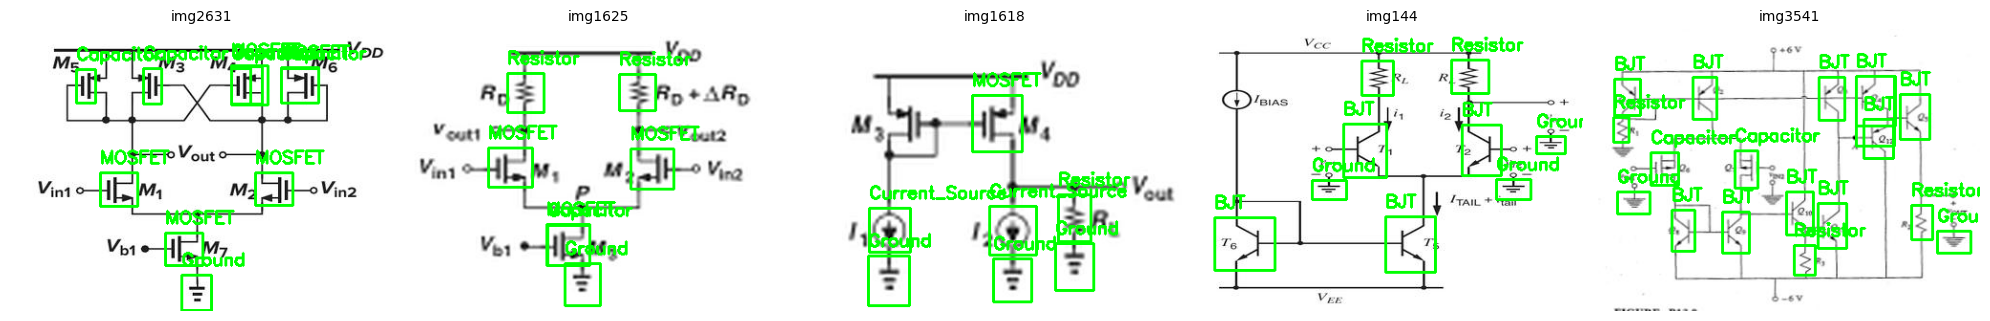

In [60]:
# %%
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Root of your processed data
processed_root = Path("data/processed")

# Gather all folders that contain a detected_components.png
folders = [
    d for d in processed_root.iterdir()
    if d.is_dir() and (d / "detected_components.png").exists()
]

# Randomly sample up to 10 folders
sample_folders = random.sample(folders, min(5, len(folders)))

# Set up the subplots: one row, one column per sample
fig, axs = plt.subplots(
    1,
    len(sample_folders),
    figsize=(4 * len(sample_folders), 4),
    squeeze=False
)
axs = axs[0]  # get the list of Axes

for ax, img_dir in zip(axs, sample_folders):
    img_path = img_dir / "detected_components.png"
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img)
    ax.set_title(img_dir.name, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


## 🔠 Text Extraction using EasyOCR
In this section, we extract textual annotations from each schematic using EasyOCR. These include component values (e.g., "10k", "1uF") and other relevant labels. We save the extracted text and their bounding boxes to JSON files for later use in component-text matching.


In [61]:
from scripts.ocr_utils import extract_text_with_positions
from scripts.image_utils import list_images
from pathlib import Path
import random
import json
from PIL import Image
import matplotlib.pyplot as plt

# OCR all raw images and save results
image_paths = list_images("data/preprocessed", exts=[".jpg", ".png", ".jpeg", ".pdf"])
print(f"📄 Found {len(image_paths)} images to OCR...")

for path in image_paths:
    img_id = Path(path).stem.replace("_preprocessed", "")  # <== FIX HERE
    save_json_path = f"data/processed/{img_id}/ocr_output.json"
    extract_text_with_positions(path, save_path=save_json_path)


print("✅ OCR text extraction completed for all images.")

# Display 10 random results
sample_paths = random.sample(image_paths, min(10, len(image_paths)))
for path in sample_paths:
    img_id = Path(path).stem.replace("_preprocessed","")
    img = Image.open(path)
    json_path = f"data/processed/{img_id}/ocr_output.json"

    with open(json_path, "r") as f:
        data = json.load(f)

    #print(f"\n🖼️ Image: {img_id} — {len(data)} text entries found")
    #for entry in data:
        #print(f"🔹 {entry['text']} @ {entry['bbox']}")


Debug: Found 330 images in data/preprocessed
📄 Found 330 images to OCR...
✅ OCR text extraction completed for all images.


## Stage 3: Image Cleaning (Component & Text Removal)

Before we can reliably detect schematic lines and nets, we need to remove all component graphics and overlaid text labels from our preprocessed images. In this cell, we will:

> **Note:** From here onward, all line-detection and net-processing steps are performed in `line_processing.ipynb`.  


In [62]:
import cv2
import numpy as np
import os
import json
from pathlib import Path
from scripts.remove_functions import remove_components, remove_text

# Set paths
PREPROCESSED_DIR = Path("data/preprocessed")
PROCESSED_DIR = Path("data/processed")

# List preprocessed images
image_files = [f for f in os.listdir(PREPROCESSED_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]

for img_name in image_files:
    img_path = PREPROCESSED_DIR / img_name
    img = cv2.imread(str(img_path))
    
    if img is None:
        print(f"❌ Failed to load image: {img_path}")
        continue

    # Extract imgid by stripping "_preprocessed"
    img_id = Path(img_name).stem.replace("_preprocessed", "")
    image_output_dir = PROCESSED_DIR / img_id
    components_path = image_output_dir / "components.json"
    ocr_path = image_output_dir / "ocr_output.json"

    # ✅ Load YOLO component bounding boxes
    if not components_path.exists():
        print(f"⚠️ components.json missing for {img_id}, skipping.")
        continue
    with open(components_path, 'r') as f:
        components = json.load(f)
    component_boxes = np.array([item["bbox"] for item in components if "bbox" in item], dtype=np.int32)

    # ✅ Remove components
    img_no_components = remove_components(img, component_boxes)

    # ✅ Load OCR text boxes and remove text
    if ocr_path.exists():
        with open(ocr_path, 'r') as f:
            ocr_data = json.load(f)
        img_no_text = remove_text(img_no_components, ocr_data)
    else:
        print(f"⚠️ ocr_output.json missing for {img_id}, skipping text removal.")
        img_no_text = img_no_components

    # ✅ Save cleaned image as <imgid>_cleaned.png inside its folder
    cleaned_img_name = f"cleaned.png"
    processed_img_path = image_output_dir / cleaned_img_name
    cv2.imwrite(str(processed_img_path), img_no_text)
    

    # (Optional) Save a backup of bounding boxes
    bbox_backup_path = image_output_dir / f"bounding_boxes.json"
    with open(bbox_backup_path, 'w') as f:
        json.dump({"bounding_boxes": component_boxes.tolist()}, f, indent=4)


### 🖼️ Random Visualization of Cleaned Schematic Images

This cell randomly selects **5 cleaned schematic images** from the `data/processed/` directory and displays them.



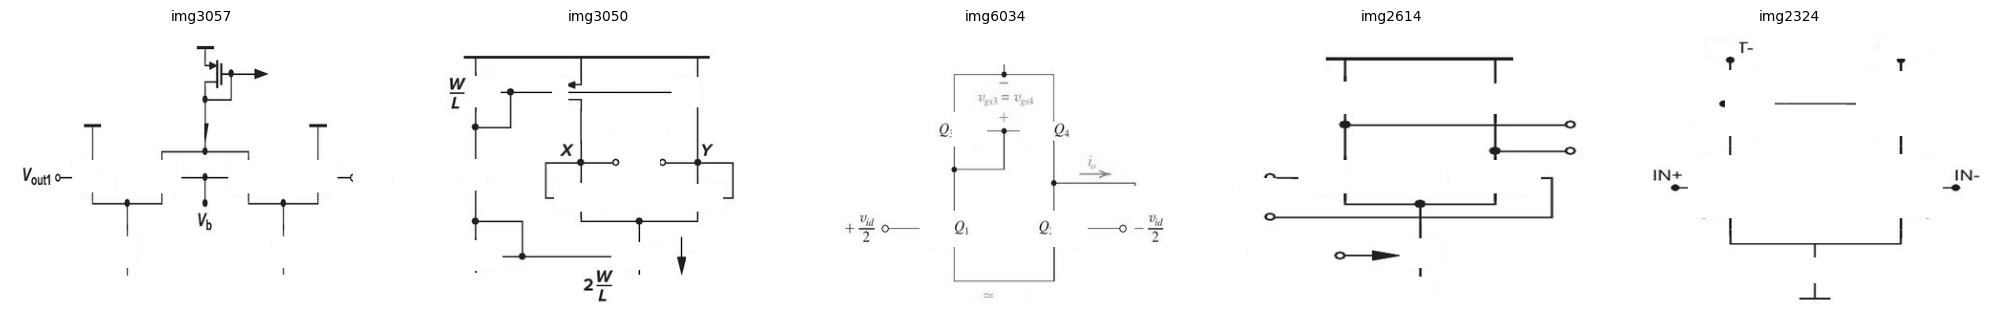

In [63]:
# %%
import os
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Set root directory where cleaned images are saved
PROCESSED_DIR = Path("data/processed")

# Gather all cleaned image paths recursively
cleaned_images = list(PROCESSED_DIR.rglob("cleaned.png"))

# Randomly select up to 10 cleaned images
sample_images = random.sample(cleaned_images, min(5, len(cleaned_images)))

# Determine grid size (e.g., 2 rows of 5)
n = len(sample_images)
cols = min(5, n)
rows = (n + cols - 1) // cols

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axs = axs.flatten()

for ax, img_path in zip(axs, sample_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"{img_path.parent.name}", fontsize=10)
    ax.axis('off')

# Turn off any unused subplots
for ax in axs[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## Sub-Block Detection with YOLOv8

In this section we:

1. **Locate the project root** (so all relative paths resolve correctly when running in `notebooks/`).
2. **Load our fine-tuned YOLOv8 model** (`yolov8_best.pt`) from the `trained_models/` folder.
3. **Iterate over each preprocessed image** in `data/preprocessed/`.
4. **Run inference** to detect analog sub-blocks (differential pairs, cascodes, current mirrors).
5. **Save**:
   - An annotated PNG with bounding boxes under  
     `data/processed/<img_id>/subblocks/<img_id>_subblocks.png`  
   - A JSON file of raw box coordinates and class labels under  
     `data/processed/<img_id>/subblocks/<img_id>_subblocks.json`

You can then visualize these outputs or feed the JSON into downstream verification steps.


### Batch Inference + JSON Export (Fixed Serialization)

This cell will:

1. Load your fine-tuned YOLOv8 checkpoint (`exp_stage2_best.pt`).  
2. Glob every `*.png` in `data/preprocessed/`.  
3. Run inference on each image.  
4. Display the annotated result (comment out `plt.show()` to skip inline).  
5. Write under `data/processed/<img_id>/`:
   - **PNG**: `<img_id>_detected.png`  
   - **JSON**: `<img_id>_detections.json`, with Python-native `int` and `float` values.  


In [64]:
# Cell 1: Batch Inference (silent)
import sys, os, json
from pathlib import Path
import cv2
from ultralytics import YOLO

# locate & cd into project root
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

# load model
MODEL_PATH = PROJECT_ROOT / "trained_models" / "exp_stage2_best.pt"
model      = YOLO(str(MODEL_PATH))

# helper to run inference + save
def detect_save(img_path, conf=0.3, out_dir=None):
    res = model.predict(source=str(img_path), conf=conf, verbose=False)[0]
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dets = []
    for box_arr, cls_idx, score in zip(
            res.boxes.xyxy.cpu().numpy(),
            res.boxes.cls.cpu().numpy(),
            res.boxes.conf.cpu().numpy()):
        x1,y1,x2,y2 = [int(v) for v in box_arr]
        s = float(score)
        c = int(cls_idx)
        lbl = model.names[c]
        dets.append({"class":lbl, "confidence":s, "bbox":[x1,y1,x2,y2]})
        cv2.rectangle(img_rgb, (x1,y1), (x2,y2), (255,0,0), 2)
        cv2.putText(img_rgb, f"{lbl} {s:.2f}", (x1,y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    if out_dir:
        out_dir.mkdir(parents=True, exist_ok=True)
        cv2.imwrite(str(out_dir/f"subblock_detected.png"),
                    cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
        with open(out_dir/f"subblock_detections.json","w") as jf:
            json.dump(dets, jf, indent=2)

PRE_DIR  = PROJECT_ROOT/"data"/"preprocessed"
PROC_DIR = PROJECT_ROOT/"data"/"processed"
for img_path in sorted(PRE_DIR.glob("*.png")):
    detect_save(img_path, conf=0.45, out_dir=PROC_DIR/img_path.stem)


### Randomly plotting 5 images for subblock detection

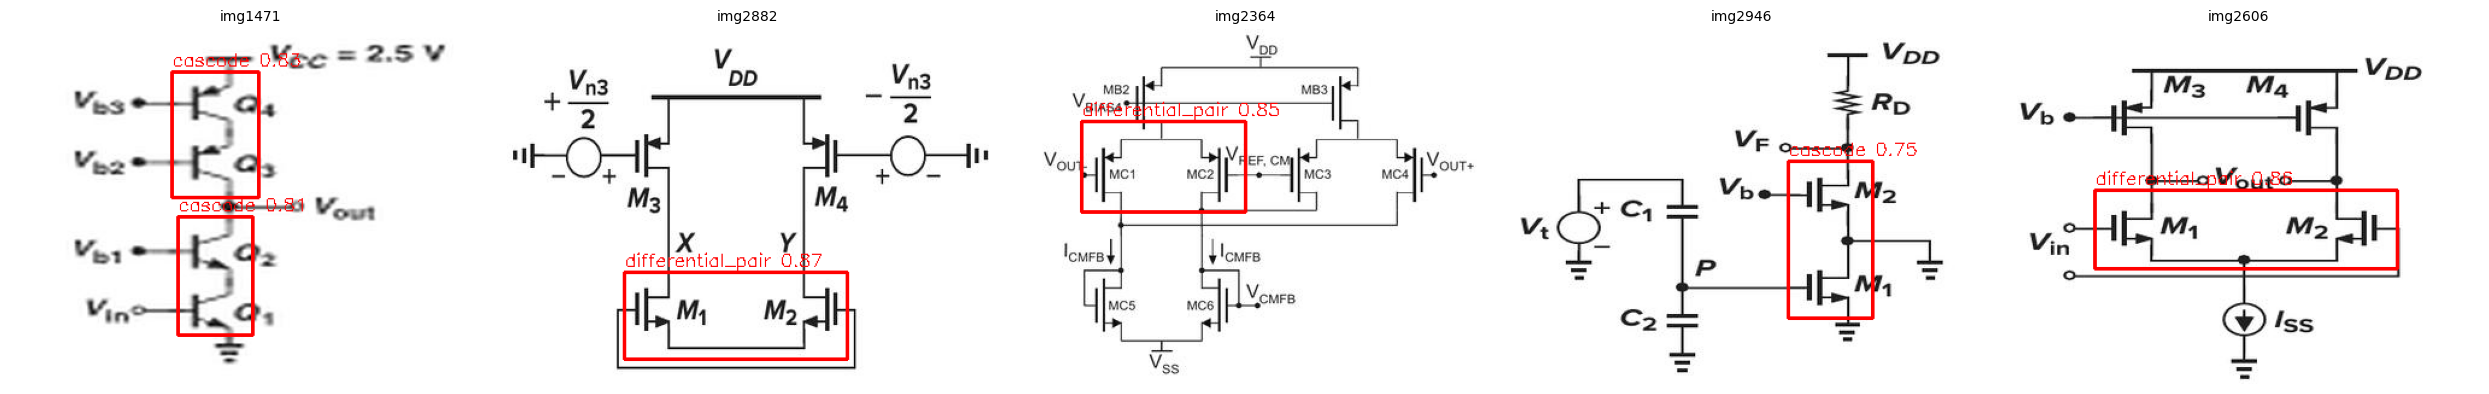

In [69]:
# Cell 2: Randomly pick 5 and plot in a single grid
import random
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

# Locate project root
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# Directory with detected images
DET_DIR = PROJECT_ROOT / "data" / "processed"

# Find all '*_detected.png' files
all_detected = list(DET_DIR.rglob("*_detected.png"))

# Sample up to 5 images
sampled = random.sample(all_detected, min(5, len(all_detected)))

# Determine grid layout: 1 row, len(sampled) columns
n = len(sampled)
fig, axs = plt.subplots(1, n, figsize=(5 * n, 5), squeeze=False)
axs = axs[0]

for ax, img_path in zip(axs, sampled):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(img_path.parent.name, fontsize=10)
    ax.axis("off")

# Turn off any unused subplots (if less than n)
for ax in axs[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()
